In [1]:
import numpy as np
import gpflow

#It's the old package without your updates... can change after sync repository
#As such, will need to pull "master" for this to work
from thermoextrap.xtrapy import core
from thermoextrap.xtrapy import xpan_beta
from thermoextrap.xtrapy import xpan_volume
from thermoextrap.xtrapy import xpan_GPR
from thermoextrap import ig

import matplotlib.pyplot as plt

In [34]:
from importlib import reload
reload(xpan_GPR)

<module 'thermoextrap.xtrapy.xpan_GPR' from '/Users/jim2/bin/libExtrap/thermodynamic-extrapolation/thermoextrap/xtrapy/xpan_GPR.py'>

# Ideal gas comparison

In [2]:
ig_model = ig.IGmodel()

beta_ref = np.array([0.1, 9.1])

ig_states = []
for b in beta_ref:
    this_dat = ig_model.genData(b, nConfigs=10000)
    ig_states.append(xpan_beta.factory_extrapmodel(1, b, this_dat[1], this_dat[0][:, None],
                                                   xalpha=False, central=True))


In [4]:
ig_gpr = xpan_GPR.factory_rbf_gprmodel(ig_states)
ig_interp = core.InterpModel(ig_states)

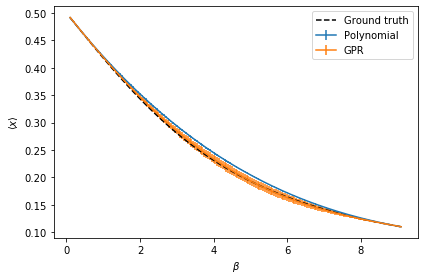

In [10]:
# %matplotlib notebook

beta_vals = np.arange(0.1, 9.15, 0.05)
avgX_vals = ig_model.avgX(beta_vals)

gpr_mu, gpr_std = ig_gpr.predict(beta_vals)
interp_mu = ig_interp.predict(beta_vals)
interp_std = ig_interp.resample(100).predict(beta_vals).std('rep')

fig, ax = plt.subplots(gpr_mu.shape[1])

ax.plot(beta_vals, avgX_vals, 'k--', label='Ground truth')
ax.errorbar(beta_vals, np.squeeze(interp_mu), yerr=np.squeeze(interp_std), marker='', label='Polynomial')
ax.errorbar(beta_vals, np.squeeze(gpr_mu), yerr=np.squeeze(gpr_std), marker='', label='GPR')

ax.legend()

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle x \rangle$')

fig.tight_layout()

plt.show()

In [7]:
#For GPR, you actually have to train the parameters, unlike with polynomial where they are just known
#Look at impact of training a little more
#First print current parameters (default training is for 100 steps)
gpflow.utilities.print_summary(ig_gpr.gp)

╒════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name               │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ list[0].kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.3504900449260276                                   │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ list[0].kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.077481390835564                                    │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────

In [8]:
#Train for another 100 steps
ig_gpr._train_GP(*ig_gpr._collect_data(), opt_steps=100)

In [9]:
#Look at parameters again
gpflow.utilities.print_summary(ig_gpr.gp)

╒════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name               │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ list[0].kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.35163930335501065                                  │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ list[0].kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.062670157564934                                    │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────

# Water RDFs in temperature (vector observable)

In [28]:
import sys, os
import glob
import simtk.unit as u

#Define some constants that we will use
kB = u.BOLTZMANN_CONSTANT_kB*u.AVOGADRO_CONSTANT_NA

#Figure out the files we want to work with
tDirs = glob.glob('/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T*K')
tDirs = sorted(tDirs)
print(tDirs)

#Get actual temperatures
tVals = np.array([float(s.split('/')[-1][1:-1]) for s in tDirs])
print(tVals)
betaVals = 1.0/(kB*tVals*u.kelvin).value_in_unit(u.kilojoule_per_mole)

#Define standardized names of files
rdfHistFile = 'refT_RDF_histograms.txt'
volumeFile = 'refT_volumes.txt'
energyFile = 'energy.xvg'
rdfFile = 'refT_RDF.txt'
threeBodyHistFile = 'refT_3body_histograms.txt'
threeBodyFile = 'refT_3body.txt'
qFile = 'refT_q.txt'
probeHSFile = 'refT_PofN.txt'
probeHSHistFile = 'refT_PofN_histograms.txt'

['/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T250K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T260K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T270K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T275K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T280K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T290K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T310K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T320K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T330K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T340K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T350K']
[250. 260. 270. 275. 280. 290. 300. 310. 320. 330. 340. 350.]


In [29]:
#Define a function to read in a file with RDF data and set up to plot
def readRDF(inFile):
    rdfDat = np.loadtxt(inFile)
    binCents = rdfDat[:,0]
    rdfVals = rdfDat[:,1]
    binWidth = binCents[1] - binCents[0] #Assume equal width bins
    binEdges = np.hstack((binCents - 0.5*binWidth, [binCents[-1]+0.5*binWidth]))
    rdfVols = (4.0*np.pi/3.0)*((binEdges[1:]**3) - (binEdges[:-1]**3))
    return binCents, rdfVals, rdfVols

#Also nice to have a function that normalizes an RDF to integrate such that mass is conserved
def renormRDF(rdf, rdferr, avgV, vols):
    normDens = 1400.0 / avgV
    cutVol = 4.0*np.pi*(1.5**3)/3.0
    intg = np.sum(rdf*vols)
    renormFac = normDens*(intg) / (normDens*cutVol - 1.0)
    #print(normDens*np.sum((rdf-1.0)*vols))
    #print(renormFac)
    rdf /= renormFac
    #print(normDens*np.sum((rdf-1.0)*vols))
    rdferr /= renormFac
    return rdf, rdferr


In [30]:
#Get RDF data at different temperatures

#Select temperatures to use as potential references
refInds = [0, -1] #6
interpRDFdat = []
interpEnergyDat = []
for ind in refInds:
    thisDir = tDirs[ind]
    rdfHistDat = np.loadtxt('%s/%s'%(thisDir, rdfHistFile))
    energyDat = np.loadtxt('%s/%s'%(thisDir, energyFile))[::5, 2] #Energies saved 5 times as frequently as configs
    interpRDFdat.append(rdfHistDat)
    interpEnergyDat.append(energyDat)

#Also need some information to normalize extrapolated/interpolated RDFs properly
binCents, refRDF, rdfVols = readRDF('%s/%s'%(tDirs[refInds[0]], rdfFile))

#If in NPT would absolutely need volume information to add pV to U
#Here just need volume to normalize RDFs correctly
volumeDat = np.loadtxt('%s/%s'%(tDirs[refInds[0]], volumeFile))
avgV = np.average(volumeDat)


In [35]:
#Set up ExtrapModel states
water_RDFs = [xpan_beta.factory_extrapmodel(order=1, alpha0=betaVals[ind],
                                            uv=interpEnergyDat[i], xv=interpRDFdat[i],
                                            central=False, xalpha=False, minus_log=False, alpha_name='beta')
              for i, ind in enumerate(refInds)]

#Create interpolation and GPR models
interp_rdfs = core.InterpModel(water_RDFs)
gpr_rdfs = xpan_GPR.factory_rbf_gprmodel(water_RDFs)

In [36]:
#Make all predictions
poly_predict = interp_rdfs.predict(betaVals)
poly_err = interp_rdfs.resample(100).predict(betaVals).std('rep')
gpr_predict, gpr_err = gpr_rdfs.predict(betaVals)

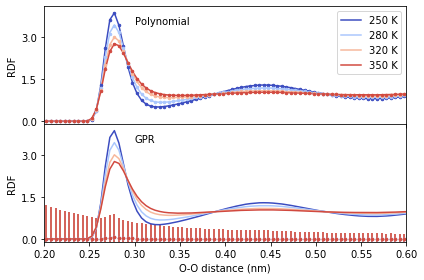

In [37]:
#Loop over RDFs and plot true and interpolated
from matplotlib.ticker import MaxNLocator

#Set up plot to compare different temperatures
fig, ax = plt.subplots(2, sharex=True, sharey=True)

#Set up color cycle in a nice way
tColors = plt.cm.coolwarm(np.arange(0.0, 1.0, float(1.0/len(tDirs))))

for i in np.hstack((np.arange(0, len(tDirs), 4), [-1])):
    
    #Load data for the RDF at the temperature we're extrapolating to
    thisCents, thisRDF, thisVols = readRDF('%s/%s'%(tDirs[i], rdfFile))
    
    #Plot original data on all axes
    for a in ax:
        a.plot(thisCents, thisRDF, '-', color=tColors[i], label='%3.0f K'%(tVals[i]))
    
    ax[0].errorbar(binCents, poly_predict.sel(beta=betaVals[i]) / (rdfVols/avgV),
                   yerr=poly_err.sel(beta=betaVals[i]) / (rdfVols/avgV),
                   marker='o', linestyle='', color=tColors[i], markersize=2.5)
    ax[1].errorbar(binCents, gpr_predict.sel(beta=betaVals[i]) / (rdfVols/avgV),
                   yerr=gpr_err.sel(beta=betaVals[i]) / (rdfVols/avgV),
                   marker='o', linestyle='', color=tColors[i], markersize=2.5)

for a in ax:
    a.set_ylabel('RDF')
    a.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='lower'))
    a.tick_params(axis='both', labelsize=10)

ax[-1].set_xlabel('O-O distance (nm)')
ax[-1].set_xlim([0.2, 0.6])
ax[-1].set_ylim([-0.1, 4.1])
ax[0].legend()

ax[0].annotate(r'Polynomial', xy=(0.25, 0.85), xycoords='axes fraction', fontsize=10)
ax[1].annotate(r'GPR', xy=(0.25, 0.85), xycoords='axes fraction', fontsize=10)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

It turns out that vector observables with a large dimension are very difficult for the GPR. Training is slow (the above took almost half an hour) and the performance is poor. The poor performance is likely due in part to training all points simultaneously, but I am not exactly sure why. It may have to do with large differences in values or relative uncertainties. For instance, at low distances, the RDF is exactly zero, and the uncertainty is assumed to be very near the smallest float32 possible to avoid blowing up the GPR. At low distances close to where the RDF begins increasing, however, the values are still close to zero but the uncertainty is high.

# Water density comparison

In [11]:
import sys, os
import glob
import simtk.unit as u

#Define some constants that we will use
kB = u.BOLTZMANN_CONSTANT_kB*u.AVOGADRO_CONSTANT_NA

#Figure out the files we want to work with
T = 300
beta = 1.0/(kB*T*u.kelvin).value_in_unit(u.kilojoule_per_mole)
dDirs = glob.glob('/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens*/T%iK'%T)
dDirs = sorted(dDirs)#[:-1]
print(dDirs)

#Get actual densities
dVals = [float(s.split('/')[-2][4:]) for s in dDirs]
print(dVals)

edgeVals = np.zeros(len(dVals))
#And actual edge lengths because more accurate from the gro files
for i, d in enumerate(dDirs):
    with open('%s/nvt.gro'%d, 'rb') as f:
        f.seek(-2, os.SEEK_END)     # Jump to the second last byte.
        while f.read(1) != b"\n":   # Until EOL is found...
            f.seek(-2, os.SEEK_CUR) # ...jump back the read byte plus one more.
        last = f.readline()         # Read last line.
        edgeVals[i] = float(last.strip().split()[-1])
print(edgeVals)
volVals = edgeVals**3

#Define standardized names of files
rdfHistFile = 'refT_RDF_histograms.txt'
volumeFile = 'refT_volumes.txt'
energyFile = 'energy.xvg'
rdfFile = 'refT_RDF.txt'
threeBodyHistFile = 'refT_3body_histograms.txt'
threeBodyFile = 'refT_3body.txt'
qFile = 'refT_q.txt' #Just going to work with this one, really
probeHSFile = 'refT_PofN.txt'
probeHSHistFile = 'refT_PofN_histograms.txt'

['/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.87/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.90/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens0.95/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.00/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.05/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.10/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.15/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.20/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.30/T300K', '/Users/jim2/Structure_Extrapolation/water/data/tip4p2005/dens1.40/T300K']
[0.87, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4]
[3.6378 3.5969 3.5326 3.4727 3.4167 3.3641 3.3147 3.268  3.1819 3.1043]


In [20]:
#Collect data for the tetrahedral order parameter

refInds = [0, 2, -1]

#Using two most extreme densities for interpolation and GPR training
interpqdat = []
interpVirialDat = []
for ind in refInds:
    compDir = dDirs[ind] #'%s/extended_2016.1'%(dDirs[ind]) #dDirs[ind]
    interpqdat.append(np.loadtxt('%s/%s'%(compDir, qFile))[:, None])
    energyDat = np.loadtxt('%s/%s'%(compDir, energyFile))
    virialDat = (-2.0)*(energyDat[:,-3] + energyDat[:,-2] + energyDat[:,-1])
    virialDat = beta*virialDat[::5] #Energies saved more frequently than structural data
    interpVirialDat.append(virialDat)

#Make numpy
interpqdat = np.array(interpqdat)
interpVirialDat = np.array(interpVirialDat)

#Save all true q values as a function of density
trueq = np.zeros(len(dDirs))

#Loop over all densities
for i in np.arange(0, len(dDirs)):
    
    print('\n\t%1.2f'%(dVals[i])+r' g/cm$^3$ :')
    
    #Load data for the average q at the density we're extrapolating to
#     try:
#         thisqDat = np.loadtxt('%s/extended_2016.1/%s'%(dDirs[i], qFile))
#         print('Using longer sim!')
#     except OSError:
    thisqDat = np.loadtxt('%s/%s'%(dDirs[i], qFile))

    thisq = np.average(thisqDat)
    thisqStd = np.std(thisqDat, ddof=1)
    trueq[i] = thisq
    
    print('\t\tTrue value: %f +/- %f'%(thisq, thisqStd))



	0.87 g/cm$^3$ :
		True value: 0.679508 +/- 0.007424

	0.90 g/cm$^3$ :
		True value: 0.683093 +/- 0.006977

	0.95 g/cm$^3$ :
		True value: 0.677332 +/- 0.006726

	1.00 g/cm$^3$ :
		True value: 0.665811 +/- 0.006081

	1.05 g/cm$^3$ :
		True value: 0.652765 +/- 0.006006

	1.10 g/cm$^3$ :
		True value: 0.639312 +/- 0.005725

	1.15 g/cm$^3$ :
		True value: 0.626090 +/- 0.005734

	1.20 g/cm$^3$ :
		True value: 0.613394 +/- 0.005515

	1.30 g/cm$^3$ :
		True value: 0.590084 +/- 0.005361

	1.40 g/cm$^3$ :
		True value: 0.569945 +/- 0.005430


In [21]:
#Define volume derivative function for q
class VolumeDerivFuncsq(object):
    """Calculates specific derivative values at refV with data x and W.
       Only go to first order for volume extrapolation.
       Here W represents the virial instead of the potential energy.
    """
    def __init__(self, refV=1.0):
        #If do not set refV, assumes virial data is already divided by the reference volume
        #If this is not the case, need to set refV
        #Or if need refV to also compute custom term, need to specify
        self.refV = refV

    def __getitem__(self, order):
        #Check to make sure not going past first order
        if order > 1:
            raise ValueError("Volume derivatives cannot go past 1st order"
                             +" and received %i"%order
                             +"\n(because would need derivatives of forces)")
        else:
            return self.create_deriv_func(order)

    def create_deriv_func(self, order):
        #Works only because of local scope
        #Even if order is defined somewhere outside of this class, won't affect returned func

        def func(W, xW):
            #Zeroth order derivative
            if order == 0:
                deriv_val =  xW[0]
            #First order derivative
            else:
                deriv_val = (xW[1] - xW[0]*W[1]) / (3*self.refV)
                #No correction term of tetrahedral order parameter q
            return deriv_val

        return func


In [22]:
#Set up ExtrapModel states
water_states = [core.ExtrapModel(alpha0=volVals[ind], data=xpan_beta.factory_data(uv=interpVirialDat[i],
                                                                                  xv=interpqdat[i],
                                                                                  order=1,
                                                                                  central=False,
                                                                                  xalpha=False), 
                                 coefs=core.Coefs(VolumeDerivFuncsq(refV=volVals[ind])),
                                 order=1, minus_log=False, alpha_name='volume')
                for i, ind in enumerate(refInds)]

#Create interpolation and GPR models
water_interp = core.InterpModel(water_states)
water_gpr = xpan_GPR.factory_rbf_gprmodel(water_states)

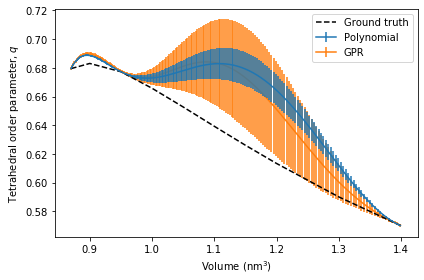

In [33]:
# %matplotlib notebook

vol_vals = np.arange(volVals[0], volVals[-1], -0.1)
dens_vals = 1400.0 / (vol_vals*(u.nanometer**3))
#Need to convert units
dens_vals *= (18.016 * (u.gram / u.mole) / u.AVOGADRO_CONSTANT_NA)
dens_vals = dens_vals.value_in_unit(u.gram / (u.centimeter**3))

gpr_mu, gpr_std = water_gpr.predict(vol_vals)
interp_mu = water_interp.predict(vol_vals)
interp_std = water_interp.resample(100).predict(vol_vals).std('rep')

fig, ax = plt.subplots()

ax.plot(dVals, trueq, 'k--', label='Ground truth')
ax.errorbar(dens_vals, np.squeeze(interp_mu), yerr=np.squeeze(interp_std), marker='', label='Polynomial')
ax.errorbar(dens_vals, np.squeeze(gpr_mu), yerr=np.squeeze(gpr_std), marker='', label='GPR', zorder=0)

ax.legend()

ax.set_xlabel(r'Volume (nm$^3$)')
ax.set_ylabel(r'Tetrahedral order parameter, $q$')

fig.tight_layout()

plt.show()

In [24]:
#For GPR, you actually have to train the parameters, unlike with polynomial where they are just known
#Look at impact of training a little more
#First print current parameters (default training is for 100 steps)
gpflow.utilities.print_summary(water_gpr.gp)

╒════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name               │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ list[0].kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.22049912392451163                                  │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ list[0].kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 7.312650474757144                                    │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────

In [31]:
#Train for another 100 steps
water_gpr._train_GP(*water_gpr._collect_data(), opt_steps=100)

In [32]:
#Look at parameters again
gpflow.utilities.print_summary(water_gpr.gp)

╒════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name               │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ list[0].kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.22216372425404146                                  │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ list[0].kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 7.33684047279211                                     │
├────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────